<a href="https://colab.research.google.com/github/annarm1/compling/blob/main/convnet_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: бинарная классификация отзывов с помощью CNN

Применить CNN для анализа тональности текста (положительный/отрицательный отзыв)

Заполните пропущенный код (`### ВАШ КОД ЗДЕСЬ ###`). **Не меняйте структуру ячеек!** Все ответы и графики должны генерироваться автоматически

**Критерии проверки (максимум 10 баллов):**
*   **2 балла** — корректная загрузка и предобработка данных.
*   **3 балла** — корректно собранная модель по спецификации.
*   **2 балла** — успешное обучение модели (вывод истории обучения).
*   **3 балла** — оценка на тесте и выводы (accuracy > 0.85 даёт +1 балл).

---

## БЛОК 1: Загрузка данных

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2JA3K9_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2JA3K9_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2JA3K9_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Тренировочные данные: 25000 samples
Тестовые данные: 25000 samples


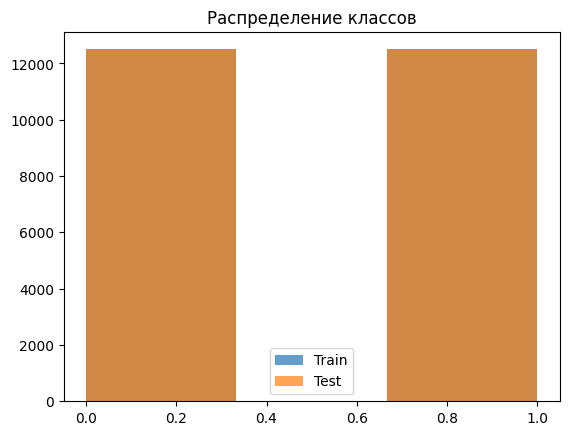

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# 1. Загрузите датасет IMDB Reviews (бинарная классификация)
(dataset_train, dataset_test), dataset_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,   # Возвращает в формате (текст, метка)
    with_info=True
)

# numpy массивы
x_train, y_train = [], []
x_test, y_test = [], []

for text, label in dataset_train:  # тренировочные данные
    x_train.append(text.numpy())
    y_train.append(label.numpy())

for text, label in dataset_test:    # тестовые данные
    x_test.append(text.numpy())
    y_test.append(label.numpy())

# numpy массивы
x_train = np.array(x_train, dtype=object)
y_train = np.array(y_train)

x_test = np.array(x_test, dtype=object)
y_test = np.array(y_test)

print(f"Тренировочные данные: {len(x_train)} samples")
print(f"Тестовые данные: {len(x_test)} samples")

# 2. Визуализируйте распределение классов
plt.hist(y_train, bins=3, alpha=0.7, label='Train')
plt.hist(y_test, bins=3, alpha=0.7, label='Test')
plt.legend()
plt.title('Распределение классов')
plt.show()

## БЛОК 2: Предобработка текста

In [15]:
# 3. Создайте текстовый векторзатор (TextVectorization)
# Ограничьте словарь 10_000 самых частых слов, максимальную длину последовательности — 200 слов

vectorizer = keras.layers.TextVectorization(
    max_tokens=10_000,
    output_sequence_length=200,
    standardize='lower_and_strip_punctuation',
    split='whitespace'
)

# 4. Адаптируйте векторзатор на тренировочных текстах
vectorizer.adapt(x_train)

# 5. Примените векторзацию к данным
x_train_vec = vectorizer(x_train).numpy()
x_test_vec = vectorizer(x_test).numpy()

print(f"Размерность после векторизации: {x_train_vec.shape}")

Размерность после векторизации: (25000, 200)


## БЛОК 3: Построение модели

In [16]:
# 6. Постройте модель CNN для текста СТРОГО ПО СПЕЦИФИКАЦИИ

model = keras.Sequential([
    # Вход: последовательность длины 200 (индексы слов)
    keras.layers.Input(shape=(200,)),
    # Embedding слой: переводит индексы слов в плотные векторы
    keras.layers.Embedding(
        input_dim=10_000,
        output_dim=128
    ),
    keras.layers.Conv1D(
        filters=64,
        kernel_size=5,
        activation='relu'
    ),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,137 (5.05 MB)

 Trainable params: 1,323,137 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

## БЛОК 4: Обучение

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.6827 - loss: 0.5601 - precision: 0.6789 - recall: 0.6542 - val_accuracy: 0.8568 - val_loss: 0.3310 - val_precision: 0.8395 - val_recall: 0.8866
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9238 - loss: 0.2047 - precision: 0.9217 - recall: 0.9266 - val_accuracy: 0.8694 - val_loss: 0.3148 - val_precision: 0.8771 - val_recall: 0.8629
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9885 - loss: 0.0513 - precision: 0.9890 - recall: 0.9881 - val_accuracy: 0.8694 - val_loss: 0.3881 - val_precision: 0.8568 - val_recall: 0.8910
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9992 - loss: 0.0080 - precision: 0.9997 - recall: 0.9987 - val_accuracy: 0.8662 - val_loss: 0.4446 - val_precision: 0.8724 - val_recall: 0.8617
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9999 - loss: 0.0015 - precision: 0.9998 - recall: 1.0000 - val_accuracy: 0.8690 - val_los

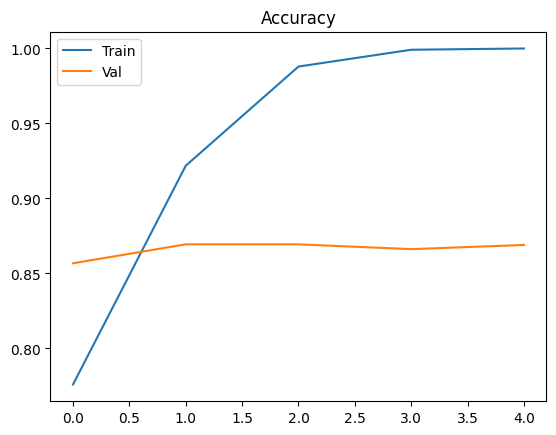

In [17]:
# 7. Скомпилируйте модель с оптимизатором 'adam', функцией потерь 'binary_crossentropy',
#    метриками ['accuracy', 'Precision', 'Recall']
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)
# 8. Обучите модель на 5 эпох с validation_split=0.2, batch_size=32
history = model.fit(
    x_train_vec,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
# 9. Постройте график точности (accuracy) на обучении и валидации
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

## БЛОК 5: Оценка

In [21]:
# 10. Оцените модель на тестовых данных

test_loss, test_acc, test_prec, test_rec = model.evaluate(
    x_test_vec,
    y_test,
    verbose=0
)

print(f"Тестовая accuracy: {test_acc:.4f}")
print(f"Тестовая precision: {test_prec:.4f}")
print(f"Тестовая recall: {test_rec:.4f}")

# 11. Сделайте предсказания на первых 10 тестовых отзывах
#     и выведите: текст отзыва, истинный класс, предсказанный класс, вероятность
for i in range(10):
    text = x_test[i]
    true_label = "POS" if y_test[i] == 1 else "NEG"

    pred_prob = model.predict(x_test_vec[i:i+1], verbose=0)
    pred_label = "POS" if pred_prob > 0.5 else "NEG"

    print(f"{i+1}) {text[:100]}... | True: {true_label} | Pred: {pred_label} ({pred_prob[0][0]:.2f})")

Тестовая accuracy: 0.8640
Тестовая precision: 0.8638
Тестовая recall: 0.8643
1)b'There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smi'... | True: POS | Pred: POS (0.72)
2)b'A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was ab'... | True: POS | Pred: NEG (0.35)
3)b'Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Movie and Another Gay M'... | True: NEG | Pred: NEG (0.00)
4)b'Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing "feel-good" mov'... | True: NEG | Pred: NEG (0.00)
5)b'As a former Erasmus student I enjoyed this film very much. It was so realistic and funny. It really '... | True: POS | Pred: POS (1.00)
6)b'My God, Ryan Gosling has made a lot of deep characters in his career, this is one of his wonderful a'... | True: POS | Pred: POS (1.00)
7)b"This film just won the best film award at the Cleveland International Film Fest

## БЛОК 6: Выводы

**Ответьте на вопросы в этой ячейке (текстом):**

1.  Какая итоговая точность (accuracy) на тесте?
2.  Что показывает разница между точностью на обучении и валидации? Есть ли переобучение?
3.  Какой из 10 показанных отзывов был классифицирован неверно? Почему, на ваш взгляд?

**Мои ответы:**
1.  Итоговая точность модели: 0,8663 (модель корректно определяет тональность 86,63% отзывов).
2.  Разрыв между точностью на обучении и валидации не большой, что значит, что модель не переобучивается критично и хорошо обобщает данные. На графике также видно, что кривые и обучения относительно стабильны.
3.  Неверно классифицирован 10-й отзыв. Возможно, формулировка отзыва может быть слишком нейтральной (например, тон самого текста имеет даже слегка академический флер, вроде эссе или формальной лицензии), что может вызывать ошибку у модели. Особенно если другие отзывы написаны в более эмоциональной манере.